Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [32]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### Build Logistic Regression with L2 Regularization

In [18]:
batch_size = 128
betaL2 = 0.001

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    bias1 = tf.Variable(tf.zeros([num_labels]))
    
    #Training
    logits = tf.matmul(tf_train_dataset, weights1) + bias1
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) \
        + betaL2*tf.nn.l2_loss(weights1))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_dataset, weights1) + bias1)
    test_prediction = tf.nn.softmax(tf.matmul(test_dataset, weights1) + bias1)

In [19]:
num_steps = 5000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 21.564045
Minibatch accuracy: 15.6%
Validation accuracy: 16.9%
Minibatch loss at step 500: 3.231931
Minibatch accuracy: 74.2%
Validation accuracy: 76.3%
Minibatch loss at step 1000: 1.815189
Minibatch accuracy: 78.9%
Validation accuracy: 79.1%
Minibatch loss at step 1500: 1.275937
Minibatch accuracy: 78.9%
Validation accuracy: 80.8%
Minibatch loss at step 2000: 0.795109
Minibatch accuracy: 84.4%
Validation accuracy: 81.0%
Minibatch loss at step 2500: 0.702781
Minibatch accuracy: 89.1%
Validation accuracy: 81.6%
Minibatch loss at step 3000: 0.659449
Minibatch accuracy: 87.5%
Validation accuracy: 82.4%
Minibatch loss at step 3500: 0.875648
Minibatch accuracy: 80.5%
Validation accuracy: 82.2%
Minibatch loss at step 4000: 0.655327
Minibatch accuracy: 84.4%
Validation accuracy: 82.0%
Minibatch loss at step 4500: 0.742849
Minibatch accuracy: 79.7%
Validation accuracy: 81.8%
Test accuracy: 89.2%


### Build NN with L2 Regularization

In [43]:
batch_size = 128
num_hidden_nodes_cases = [256, 512, 1024, 2048, 4096]
betaL2s = [0.0001, 0.0005, 0.001, 0.005, 0.01]
perf = np.empty((len(num_hidden_nodes_cases), len(betaL2s)))

for i in range(len(num_hidden_nodes_cases)):
    num_hidden_nodes = num_hidden_nodes_cases[i]
    for j in range(len(betaL2s)):
        betaL2 = betaL2s[j]
        graph = tf.Graph()
        with graph.as_default():

            # Input data. For the training data, we use a placeholder that will be fed
            # at run time with a training minibatch.
            tf_train_dataset = tf.placeholder(tf.float32,
                                            shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)

            # Variables.
            weights1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_hidden_nodes]))
            bias1 = tf.Variable(tf.zeros([num_hidden_nodes]))
            weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
            bias2 = tf.Variable(tf.zeros([num_labels]))

            #Training
            lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + bias1)
            logits = tf.matmul(lay1_train, weights2) + bias2
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) \
                + betaL2*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)))

            # Optimizer.
            optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

            # Predictions for the training, validation, and test data.
            train_prediction = tf.nn.softmax(logits)
            lay1_val = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + bias1)
            valid_prediction = tf.nn.softmax(tf.matmul(lay1_val, weights2) + bias2)
            lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + bias1)
            test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + bias2)

        num_steps = 5000

        with tf.Session(graph=graph) as session:
            tf.initialize_all_variables().run()
            print("Initialized with nodes = %d and L2 of %.10f" % (num_hidden_nodes, betaL2))
            for step in range(num_steps):
                # Pick an offset within the training data, which has been randomized.
                # Note: we could use better randomization across epochs.
                offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
                # Generate a minibatch.
                batch_data = train_dataset[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]
                # Prepare a dictionary telling the session where to feed the minibatch.
                # The key of the dictionary is the placeholder node of the graph to be fed,
                # and the value is the numpy array to feed to it.
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
                _, l, predictions = session.run(
                  [optimizer, loss, train_prediction], feed_dict=feed_dict)
                if (step % 500 == 0):
                    #print("Minibatch loss at step %d: %f" % (step, l))
                    #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                    #print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                    continue

            acc = accuracy(test_prediction.eval(), test_labels)  
            print("Test accuracy: %.1f%%" % acc)

        perf[i,j] = acc

Initialized with nodes = 256 and L2 of 0.0001000000
Test accuracy: 89.7%
Initialized with nodes = 256 and L2 of 0.0005000000
Test accuracy: 92.5%
Initialized with nodes = 256 and L2 of 0.0010000000
Test accuracy: 93.5%
Initialized with nodes = 256 and L2 of 0.0050000000
Test accuracy: 91.9%
Initialized with nodes = 256 and L2 of 0.0100000000
Test accuracy: 90.4%
Initialized with nodes = 512 and L2 of 0.0001000000
Test accuracy: 90.4%
Initialized with nodes = 512 and L2 of 0.0005000000
Test accuracy: 92.8%
Initialized with nodes = 512 and L2 of 0.0010000000
Test accuracy: 93.8%
Initialized with nodes = 512 and L2 of 0.0050000000
Test accuracy: 92.0%
Initialized with nodes = 512 and L2 of 0.0100000000
Test accuracy: 90.3%
Initialized with nodes = 1024 and L2 of 0.0001000000
Test accuracy: 90.5%
Initialized with nodes = 1024 and L2 of 0.0005000000
Test accuracy: 93.3%
Initialized with nodes = 1024 and L2 of 0.0010000000
Test accuracy: 94.0%
Initialized with nodes = 1024 and L2 of 0.005000

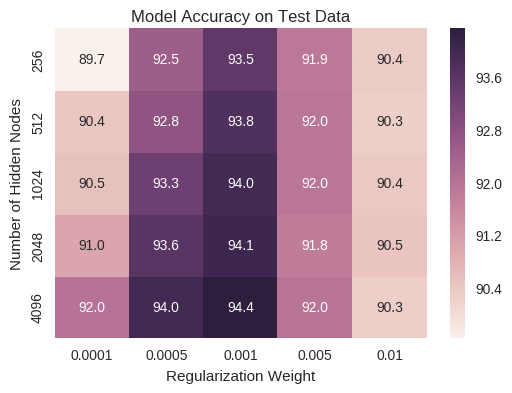

In [44]:
ax = plt.axes()
sns.heatmap(perf, xticklabels=betaL2s, yticklabels=num_hidden_nodes_cases, annot=True, fmt='.1f')
ax.set_xlabel('Regularization Weight')
ax.set_ylabel('Number of Hidden Nodes')
ax.set_title('Model Accuracy on Test Data')
#plt.set_

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [52]:
batch_size = 128
num_hidden_nodes = 1024
betaL2 = 0.0#1

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_hidden_nodes]))
    bias1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    bias2 = tf.Variable(tf.zeros([num_labels]))

    #Training
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + bias1)
    logits = tf.matmul(lay1_train, weights2) + bias2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) \
        + betaL2*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_val = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + bias1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_val, weights2) + bias2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + bias1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + bias2)

num_steps = 5000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized with nodes = %d and L2 of %.10f" % (num_hidden_nodes, betaL2))
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        batch_i = np.random.choice([1,20,300,4000])
        offset = (batch_i * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            continue

    acc = accuracy(test_prediction.eval(), test_labels)  
    print("Test accuracy: %.1f%%" % acc)

Initialized with nodes = 1024 and L2 of 0.0000000000
Minibatch loss at step 0: 398.138214
Minibatch accuracy: 16.4%
Validation accuracy: 33.8%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.7%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.7%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.7%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.7%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.7%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.7%
Minibatch loss at step 3500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.7%
Minibatch loss at step 4000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.7%
Minibatch loss at step 4500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.7%
Test accuracy: 81.7%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [57]:
batch_size = 128
num_hidden_nodes = 1024
betaL2 = 0.001

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    #keepProb = tf.placeholder(tf.float32)
    weights1 = tf.Variable(tf.truncated_normal([image_size*image_size, num_hidden_nodes]))
    bias1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    bias2 = tf.Variable(tf.zeros([num_labels]))

    #Training
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + bias1)
    lay1_dropout = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(lay1_dropout, weights2) + bias2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) \
        + betaL2*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_val = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + bias1)
    lay1_val = tf.nn.dropout(lay1_val, 1.0)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_val, weights2) + bias2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + bias1)
    lay1_test = tf.nn.dropout(lay1_test, 1.0)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + bias2)

In [61]:
num_steps = 10000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized with nodes = %d and L2 of %.10f" % (num_hidden_nodes, betaL2))
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #batch_i = np.random.choice([1,20,300,4000])
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            continue

    acc = accuracy(test_prediction.eval(), test_labels)  
    print("Test accuracy: %.1f%%" % acc)

Initialized with nodes = 1024 and L2 of 0.0010000000
Minibatch loss at step 0: 854.843567
Minibatch accuracy: 10.9%
Validation accuracy: 33.8%
Minibatch loss at step 500: 219.219696
Minibatch accuracy: 70.3%
Validation accuracy: 78.1%
Minibatch loss at step 1000: 116.647293
Minibatch accuracy: 71.9%
Validation accuracy: 80.4%
Minibatch loss at step 1500: 69.712112
Minibatch accuracy: 75.8%
Validation accuracy: 82.3%
Minibatch loss at step 2000: 41.398045
Minibatch accuracy: 83.6%
Validation accuracy: 83.7%
Minibatch loss at step 2500: 25.070587
Minibatch accuracy: 87.5%
Validation accuracy: 84.9%
Minibatch loss at step 3000: 15.431509
Minibatch accuracy: 85.9%
Validation accuracy: 85.5%
Minibatch loss at step 3500: 9.703618
Minibatch accuracy: 81.2%
Validation accuracy: 85.5%
Minibatch loss at step 4000: 6.009991
Minibatch accuracy: 85.9%
Validation accuracy: 86.4%
Minibatch loss at step 4500: 3.972458
Minibatch accuracy: 82.0%
Validation accuracy: 86.7%
Minibatch loss at step 5000: 2.

In the base case, it seems like we sacrifice a little accuracy after trianing for the same number of steps. In the extreme overfitting case, we get a significant boost in accuracy though.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [123]:
batch_size = 512
l1_nodes = 1024
l2_nodes = 1024
l3_nodes = 1024
l4_nodes = 1024
betaL2 = 0.001

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    #keepProb = tf.placeholder(tf.float32)
    global_step = tf.Variable(0) #Count the steps taken thus far
    l1_weights = tf.Variable(tf.truncated_normal([image_size*image_size, l1_nodes], stddev=np.sqrt(2.0/l1_nodes)))
    l1_bias = tf.Variable(tf.zeros([l1_nodes]))
    
    l2_weights = tf.Variable(tf.truncated_normal([l1_nodes, l2_nodes], stddev=np.sqrt(2.0/l2_nodes)))
    l2_bias = tf.Variable(tf.zeros([l2_nodes]))
    
    l3_weights = tf.Variable(tf.truncated_normal([l2_nodes, l3_nodes], stddev=np.sqrt(2.0/l3_nodes)))
    l3_bias = tf.Variable(tf.zeros([l3_nodes]))
    
    l4_weights = tf.Variable(tf.truncated_normal([l3_nodes, l4_nodes], stddev=np.sqrt(2.0/l4_nodes)))
    l4_bias = tf.Variable(tf.zeros([l4_nodes]))
    
    out_weights = tf.Variable(tf.truncated_normal([l4_nodes, num_labels], stddev=np.sqrt(2.0/l4_nodes)))
    out_bias = tf.Variable(tf.zeros([num_labels]))

    #Training
    l1_train = tf.nn.relu(tf.matmul(tf_train_dataset, l1_weights) + l1_bias)
    l1_dropout = tf.nn.dropout(l1_train, 0.5)
    l2_train = tf.nn.relu(tf.matmul(l1_dropout, l2_weights) + l2_bias)
    l2_dropout = tf.nn.dropout(l2_train, 0.5)
    l3_train = tf.nn.relu(tf.matmul(l2_dropout, l3_weights) + l3_bias)
    l3_dropout = tf.nn.dropout(l3_train, 0.5)
    l4_train = tf.nn.relu(tf.matmul(l3_dropout, l4_weights) + l4_bias)
    l4_dropout = tf.nn.dropout(l4_train, 0.5)
    
    logits = tf.matmul(l4_dropout, out_weights) + out_bias
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) \
        + betaL2*(tf.nn.l2_loss(l1_weights) + 
                  tf.nn.l2_loss(l2_weights) + 
                  tf.nn.l2_loss(l3_weights) + 
                  tf.nn.l2_loss(l4_weights) + 
                  tf.nn.l2_loss(out_weights)))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.9)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    l1_val = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, l1_weights) + l1_bias), 1.0)
    l2_val = tf.nn.dropout(tf.nn.relu(tf.matmul(l1_val, l2_weights) + l2_bias), 1.0)
    l3_val = tf.nn.dropout(tf.nn.relu(tf.matmul(l2_val, l3_weights) + l3_bias), 1.0)
    l4_val = tf.nn.dropout(tf.nn.relu(tf.matmul(l3_val, l4_weights) + l4_bias), 1.0)
    valid_prediction = tf.nn.softmax(tf.matmul(l4_val, out_weights) + out_bias)
    l1_test = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, l1_weights) + l1_bias), 1.0)
    l2_test = tf.nn.dropout(tf.nn.relu(tf.matmul(l1_test, l2_weights) + l2_bias), 1.0)
    l3_test = tf.nn.dropout(tf.nn.relu(tf.matmul(l2_test, l3_weights) + l3_bias), 1.0)
    l4_test = tf.nn.dropout(tf.nn.relu(tf.matmul(l3_test, l4_weights) + l4_bias), 1.0)
    test_prediction = tf.nn.softmax(tf.matmul(l4_test, out_weights) + out_bias)

In [126]:
num_steps = 1000000
lr = []
mb_acc =[]
val_acc = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized with nodes = %d and L2 of %.10f" % (l1_nodes, betaL2))
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #batch_i = np.random.choice([1,20,300,4000])
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions, l_rate = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            lr.append(l_rate)
            mb_acc.append(accuracy(predictions, batch_labels))
            val_acc.append(accuracy(valid_prediction.eval(), valid_labels))
        
        if (step % 2000 == 0):
            print("Current learning rate = %.5f" % l_rate)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            continue

    acc = accuracy(test_prediction.eval(), test_labels)  
    print("Test accuracy: %.1f%%" % acc)

Initialized with nodes = 1024 and L2 of 0.0010000000
Current learning rate = 0.50000
Minibatch loss at step 0: 6.056422
Minibatch accuracy: 8.2%
Validation accuracy: 17.7%
Current learning rate = 0.40500
Minibatch loss at step 2000: 0.885246
Minibatch accuracy: 91.2%
Validation accuracy: 88.7%
Current learning rate = 0.32805
Minibatch loss at step 4000: 0.613010
Minibatch accuracy: 87.9%
Validation accuracy: 89.8%
Current learning rate = 0.26572
Minibatch loss at step 6000: 0.511973
Minibatch accuracy: 89.8%
Validation accuracy: 89.8%
Current learning rate = 0.21523
Minibatch loss at step 8000: 0.444938
Minibatch accuracy: 90.0%
Validation accuracy: 90.7%
Current learning rate = 0.17434
Minibatch loss at step 10000: 0.420176
Minibatch accuracy: 92.4%
Validation accuracy: 91.1%
Current learning rate = 0.14121
Minibatch loss at step 12000: 0.485543
Minibatch accuracy: 88.9%
Validation accuracy: 91.2%
Current learning rate = 0.11438
Minibatch loss at step 14000: 0.369352
Minibatch accurac

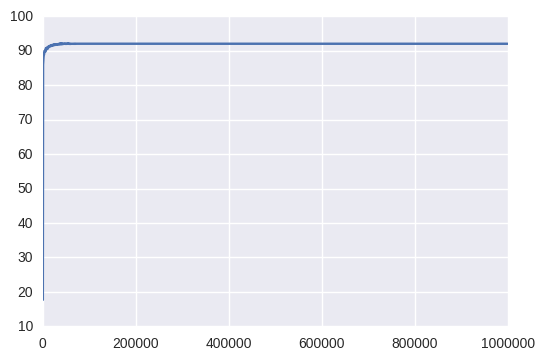

In [129]:
plt.plot(range(0,len(lr)*500,500), val_acc)